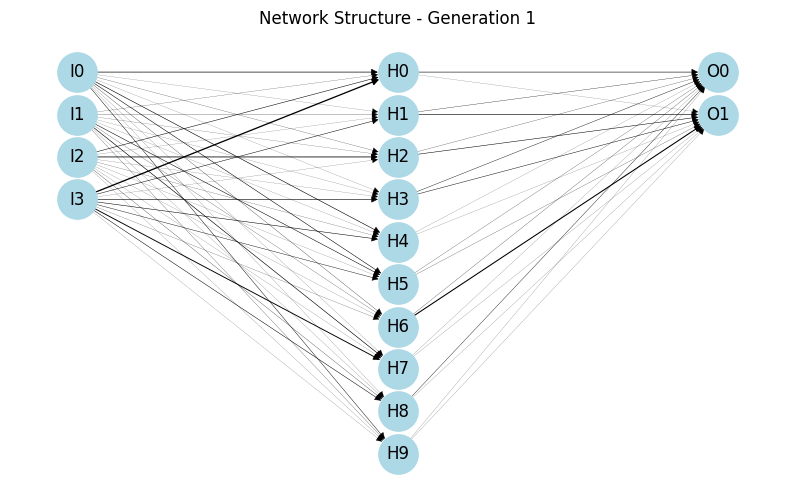

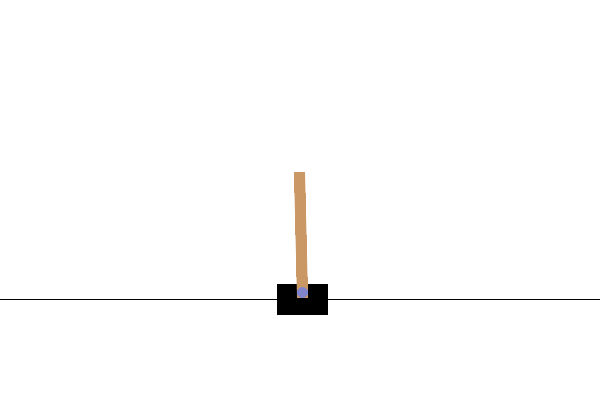

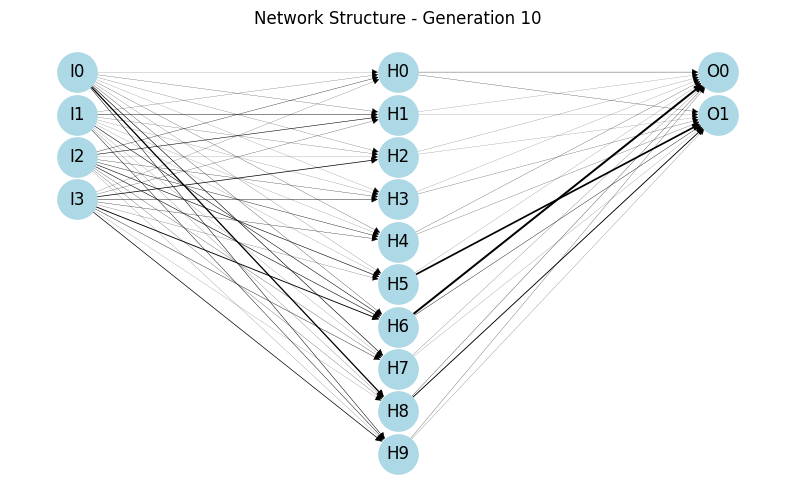

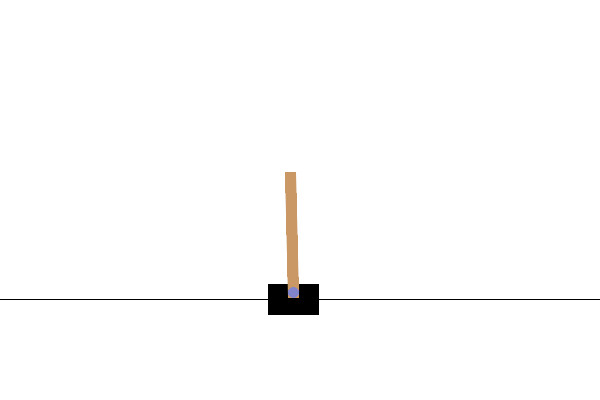

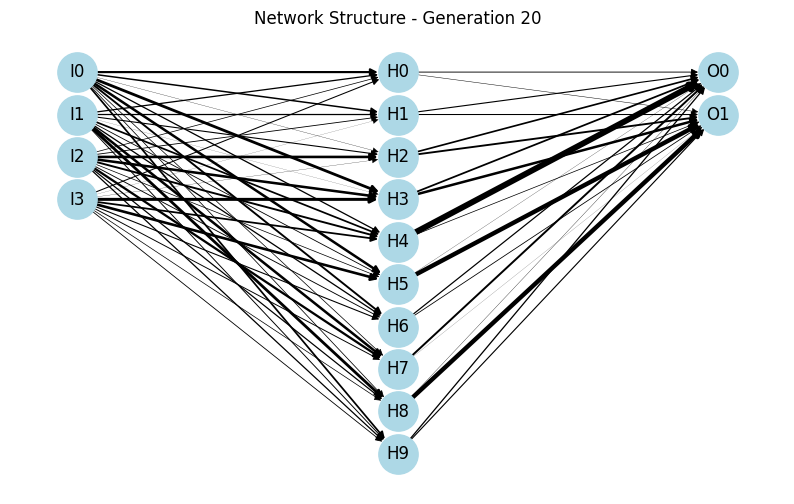

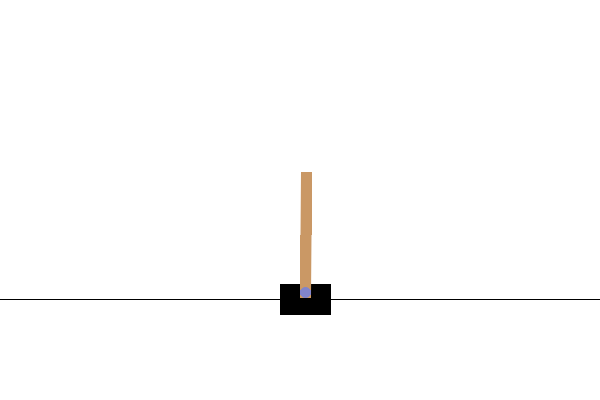

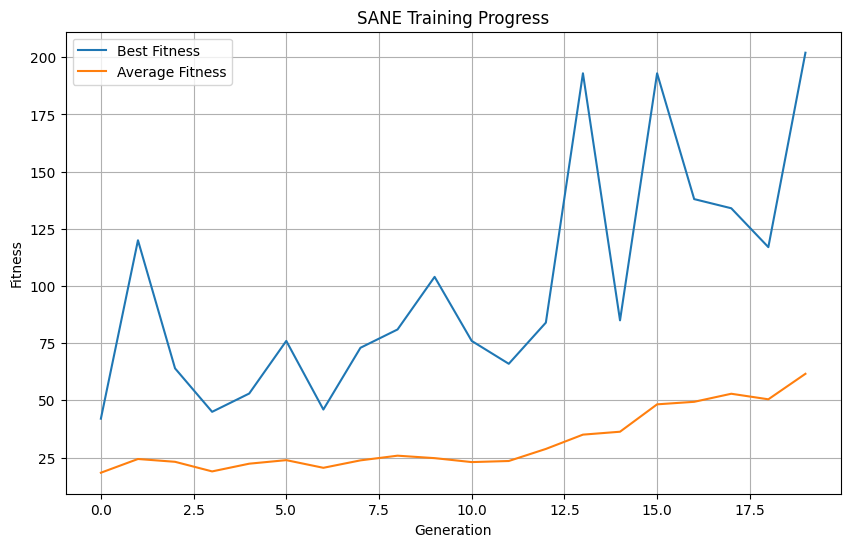

In [18]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import networkx as nx
import imageio
from IPython.display import display, Image
import io

# 神经元基因，含输入输出权重及适应度
# Ген нейрона с весами входа, выхода и фитнесом
class Neuron:
    # 初始化输入输出权重，乘0.1缩放
    # Инициализация весов входа и выхода с масштабом 0.1
    def __init__(self, input_size, output_size):
        self.input_weights = np.random.randn(input_size) * 0.1
        self.output_weights = np.random.randn(output_size) * 0.1
        self.fitness = 0.0

    # 权重变异，，输入变异概率和变异幅度
    # Мутация весов
    def mutate(self, mutation_rate=0.1, mutation_scale=0.2):
        self.input_weights += (np.random.rand(*self.input_weights.shape) < mutation_rate) * \
                              np.random.randn(*self.input_weights.shape) * mutation_scale
        self.output_weights += (np.random.rand(*self.output_weights.shape) < mutation_rate) * \
                               np.random.randn(*self.output_weights.shape) * mutation_scale

# 固定拓扑神经网络，含隐藏层神经元
# Фиксированная топология сети с набором скрытых нейронов
class NeuralNetwork:

    # 初始化隐藏层神经元和适应度
    # Инициализация скрытого слоя и фитнеса
    def __init__(self, neurons):
        self.neurons = neurons
        self.fitness = 0.0

    def forward(self, x):
        # 计算隐藏层激活，使用tanh
        # Вычисление активации скрытого слоя (tanh)
        hidden_outputs = [np.tanh(np.dot(x, neuron.input_weights)) for neuron in self.neurons]
         # 汇总隐藏层输出生成最终输出
        # Суммирование выходов скрытого слоя
        output = np.sum([h * n.output_weights for h, n in zip(hidden_outputs, self.neurons)], axis=0)
        return output

    # 在环境中评估网络表现，计算平均奖励，输入第四变量游戏运行轮数
    # Оценка сети в среде, среднее вознаграждение
    def evaluate(self, env, n_episodes=1):
        total_reward = 00
        is_discrete = isinstance(env.action_space, gym.spaces.Discrete)
        for _ in range(n_episodes):
            state, _ = env.reset()
            done = False
            while not done:
                raw_output = self.forward(state)
                if is_discrete:
                    probs = np.exp(raw_output - np.max(raw_output))
                    action = np.random.choice(len(raw_output), p=probs / probs.sum())
                else:
                    action = np.tanh(raw_output)
                state, reward, done, _, _ = env.step(action)
                total_reward += reward
        return total_reward / n_episodes

# SANE算法
# Алгоритм SANE
class SANE:
    # 初始化神经元池和网络种群
    # Инициализация пула нейронов и популяции
    def __init__(self, input_size, output_size, neuron_pool_size, population_size, hidden_size):
        self.input_size = input_size
        self.output_size = output_size
        self.neuron_pool_size = neuron_pool_size
        self.population_size = population_size
        self.hidden_size = hidden_size
        self.neuron_pool = [Neuron(input_size, output_size) for _ in range(neuron_pool_size)]
        self.population = self._create_population()
        self.best_network = None
        self.best_fitness = -np.inf

    # 随机选神经元生成网络种群
    # Случайный выбор нейронов для создания популяции сетей
    def _create_population(self):
        population = []
        for _ in range(self.population_size):
            indices = np.random.choice(len(self.neuron_pool), self.hidden_size, replace=False)
            selected_neurons = [self.neuron_pool[i] for i in indices]
            population.append(NeuralNetwork(selected_neurons))
        return population

    # 更新神经元适应度为参与网络平均适应度
    # Обновление фитнеса нейронов как среднего по сетям
    def _update_neuron_fitness(self):
        for neuron in self.neuron_pool:
            neuron.fitness, neuron.count = 0.0, 0

        for net in self.population:
            for neuron in net.neurons:
                neuron.fitness += net.fitness
                neuron.count += 1

        for neuron in self.neuron_pool:
            if neuron.count > 0:
                neuron.fitness /= neuron.count

    # 锦标赛选择两个适应度最高父代
    # Отбор родителей турниром по фитнесу
    def _select_parents(self, tournament_size=5):
        parents = []
        for _ in range(2):
            indices = np.random.choice(len(self.neuron_pool), tournament_size, replace=False)
            candidates = [self.neuron_pool[i] for i in indices]
            parent = max(candidates, key=lambda n: n.fitness)
            parents.append(parent)
        return parents

    # 输入输出权重均匀交叉
    # Равномерное скрещивание весов
    def _crossover(self, parent1, parent2):
        child = Neuron(self.input_size, self.output_size)

        cross_mask = np.random.rand(self.input_size) > 0.5
        child.input_weights = np.where(
            cross_mask,
            parent1.input_weights,
            parent2.input_weights
        )

        cross_mask = np.random.rand(self.output_size) > 0.5
        child.output_weights = np.where(
            cross_mask,
            parent1.output_weights,
            parent2.output_weights
        )
        return child

    # 更新最佳网络，进化下一代神经元和网络，第二参数是上一代每个网络的适应度
    # Обновление лучшей сети, эволюция следующего поколения
    def evolve(self, fitness_scores):
        for i, fitness in enumerate(fitness_scores):
            self.population[i].fitness = fitness

            if fitness > self.best_fitness:
                self.best_fitness = fitness
                self.best_network = self.population[i]

        self._update_neuron_fitness()

        new_neuron_pool = []
        for _ in range(self.neuron_pool_size):
            parent1, parent2 = self._select_parents()
            child = self._crossover(parent1, parent2)
            child.mutate(mutation_rate=0.15)
            new_neuron_pool.append(child)

        self.neuron_pool = new_neuron_pool

        self.population = self._create_population()

# 绘制网络结构图，边宽对应权重大小
# Визуализация структуры сети с толщиной ребер по весам
def visualize_network_structure_with_weights(network, generation):
    G = nx.DiGraph()
    num_inputs = len(network.neurons[0].input_weights)
    num_outputs = len(network.neurons[0].output_weights)
    for i in range(num_inputs): G.add_node(f"I{i}", layer="input")
    for i in range(len(network.neurons)): G.add_node(f"H{i}", layer="hidden")
    for i in range(num_outputs): G.add_node(f"O{i}", layer="output")
    edge_widths = []
    for h_id, neuron in enumerate(network.neurons):
        for i_id, weight in enumerate(neuron.input_weights):
            G.add_edge(f"I{i_id}", f"H{h_id}")
            edge_widths.append(max(0.1, abs(weight)*3))
        for o_id, weight in enumerate(neuron.output_weights):
            G.add_edge(f"H{h_id}", f"O{o_id}")
            edge_widths.append(max(0.1, abs(weight)*3))
    pos = {f"I{i}": (-2, -i) for i in range(num_inputs)}
    pos.update({f"H{i}": (0, -i) for i in range(len(network.neurons))})
    pos.update({f"O{i}": (2, -i) for i in range(num_outputs)})
    plt.figure(figsize=(10, 6))
    nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=800, width=edge_widths)
    plt.title(f"Network Structure - Generation {generation + 1}")
    plt.axis('off')
    plt.show()

# 生成gif
# Создать GIF-файл
def record_gif(env, network, n_episodes=1):
    frames = []
    is_discrete = isinstance(env.action_space, gym.spaces.Discrete)

    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            frame = env.render()
            frames.append(frame)

            raw_output = network.forward(state)
            if is_discrete:
                probabilities = np.exp(raw_output - np.max(raw_output))
                probabilities /= probabilities.sum()
                action = np.random.choice(len(raw_output), p=probabilities)
            else:
                action = np.tanh(raw_output)

            state, reward, done, _, _ = env.step(action)

    with io.BytesIO() as buffer:
      imageio.mimsave(buffer, frames, format='GIF', duration=1 / 30)
      buffer.seek(0)
      display(Image(data=buffer.read()))


# SANE训练主流程
# Основной цикл обучения SANE
def train_sane(population_size=40, hidden_size=10):
    # 创建环境，获取输入输出维度
    # Создание среды и определение размеров входа и выхода
    env_name = "CartPole-v1"
    generations = 20
    env = gym.make(env_name, render_mode="rgb_array")
    input_size = env.observation_space.shape[0]

    output_size = env.action_space.n if isinstance(env.action_space, gym.spaces.Discrete) else env.action_space.shape[0]

    # 初始化SANE算法参数
    # Инициализация параметров SANE
    sane = SANE(input_size, output_size, neuron_pool_size=100, population_size=population_size, hidden_size=hidden_size)
    best_fitness_history, avg_fitness_history = [], []

    # 评估种群适应度
    # Оценка популяции
    for gen in range(generations):
        fitness_scores = [net.evaluate(env, n_episodes=1) for net in sane.population]
        best_fitness = max(fitness_scores)
        avg_fitness = np.mean(fitness_scores)
        best_fitness_history.append(best_fitness)
        avg_fitness_history.append(avg_fitness)

        # 进化生成下一代
        # Эволюция следующего поколения
        sane.evolve(fitness_scores)

        if  gen in [0, 9, 19]:
            visualize_network_structure_with_weights(sane.best_network, gen)
            record_gif(env, sane.best_network)


    plt.figure(figsize=(10, 6))
    plt.plot(best_fitness_history, label="Best Fitness")
    plt.plot(avg_fitness_history, label="Average Fitness")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("SANE Training Progress")
    plt.legend()
    plt.grid(True)
    plt.savefig("convergence.png")
    plt.show()


    env.close()


train_sane(population_size=40, hidden_size=10)
